## Notebook for working with the X-ray Catalog

In [96]:
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy import units as u
import numpy as np
from astropy.table import Table, unique
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline
#matplotlib.matplotlib_fname()
#import linetools.utils as ltu
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import copy
from colossus.halo import profile_nfw
%config InlineBackend.figure_format = 'retina'

First, look at the RA/Dec distribution of the files Song sent

In [2]:
# get data ready
data_pth = '/users/astro/desktop/github/satellite_fraction/data/'
hsc_xmm_file = data_pth + 's16a_massive_mvir_added_xmm.fits'
xxl_xmm_file = data_pth + 'xxl365.fits'

# create tables from file data
hsc_xmm = Table(fits.open(hsc_xmm_file)[1].data)
xxl_xmm = Table(fits.open(xxl_xmm_file)[1].data)

# change the xxl catalog that is in same region as the hsc data
xxl_xmm = xxl_xmm[xxl_xmm['DEJ2000'] >= -8] # about where the hsc field ends but captures full xxl sample there

# mass cut for the HSC galaxies (logm_max > 11.4)
hsc_xmm = hsc_xmm[hsc_xmm['logm_100'] > 11.4]
hsc_xmm = hsc_xmm[hsc_xmm['z_best'] > 0.2]
hsc_xmm = hsc_xmm[hsc_xmm['z_best'] < 0.5]

Text(0,0.5,'Dec')

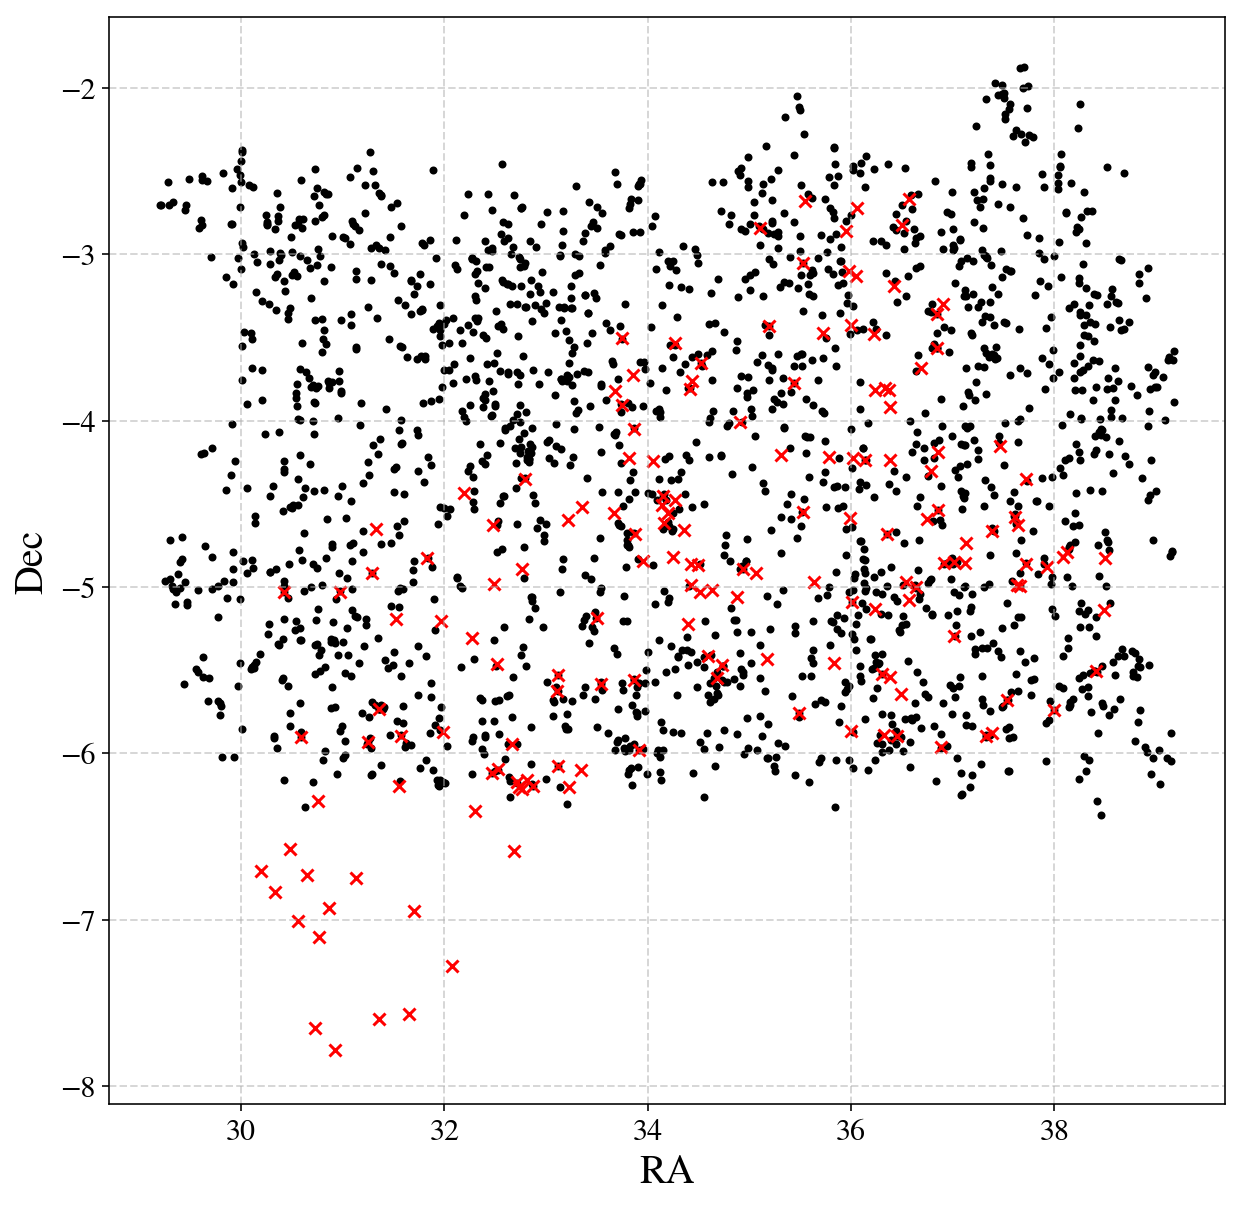

In [3]:
# plot the coordinate points
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
# hsc
ax1.scatter(hsc_xmm['ra'], hsc_xmm['dec'], marker = '.', color = 'k', label = 'HSC s16a XMM')

# xxl
ax1.scatter(xxl_xmm['RAJ2000'], xxl_xmm['DEJ2000'], marker = 'x', color = 'red', label = 'XXL XMM')

ax1.set_xlabel('RA', fontsize = 20)
ax1.set_ylabel('Dec', fontsize = 20)

We could stand to further cut the field to match (will probably retroactively go back and do that). Anyhow, based on the preliminary matching that Song did, I should start by determining which galaxies are within $r_{\mathrm vir}$ of the xray sources. In the case that there two galaxies that meet that criterion, there are two options to determine the central:

* Proximity
* Mass

Proximity is probably the route to go if there are multiple matches. The caveat here is that the x-ray gas does not perfectly trace the visible gas distribution nor does the peak of x-ray gas correspond to physical center.

In [161]:
# first, find the relevant columns for x-ray mass
#xxl_xmm.remove_column('Flags')
xxl_xmm.sort('XLSSC')
xxl_xmm

XLSSC,RAJ2000,DEJ2000,z,Class,Mgas500kpc,E_Mgas500kpc,e_mgas500kpc_lc,r500MT,T300kpc,E_T300kpc,e_t300kpc_lc,LXXL500MT,e_LXXL500MT,F60,e_F60
int16,float32,float32,float32,uint8,int16,int16,int16,int16,float32,float32,float32,float32,float32,int16,int16
1,36.238,-3.817,0.614,1,125,5,4,763,3.7,0.3,0.3,95.0,6.0,64,4
2,36.384,-3.92,0.771,1,75,7,7,560,2.5,0.2,0.2,69.0,5.0,25,3
3,36.909,-3.3,0.836,1,105,3,3,649,3.5,0.3,0.3,125.0,9.0,34,4
5,36.788,-4.301,1.058,1,69,7,7,429,2.1,0.3,0.4,52.0,8.0,9,2
6,35.439,-3.772,0.429,1,141,1,1,916,4.2,0.5,0.7,186.0,16.0,185,8
8,36.336,-3.801,0.299,1,22,4,5,564,1.6,0.2,0.2,2.0,1.0,14,3
9,36.685,-3.684,0.328,2,48,4,4,0,nan,nan,nan,nan,nan,17,4
10,36.843,-3.362,0.33,1,1,1,1,698,2.4,0.3,0.4,25.0,3.0,46,4
11,36.54,-4.969,0.054,1,13,2,2,639,1.6,0.2,0.3,1.0,1.0,32,3


So it looks like the mass column is `Mgas500kpc`. From Clerc et al. (2014), this column is in units of $10^{13} \mathrm h^{-1} M_{\odot}$

In [5]:
# Was going to do a virial radius thing, but will get back to that
xxl_mass = xxl_xmm['Mgas500kpc']

In [6]:
# I'll start by finding matching galaxies
# Going to write a new function here from my satellite finding code

pair_table = Table(names = ('xxl_id', 'T300kpc', 'hsc_id', 'z', 'hsc_logm', 'sep (arcsec)'))

def match_galaxy(i, table1, table2, z_lim):
   
    # the object we choose here is going to be a central by the way we have defined things
    xxl_gal = table1[i] 
    
    # this was a trick that song used to make a new catalog for the other objects of interest.
    # the utility is that we don't have to loop through the whole catalog EVERY TIME
    cat_match = table2
    
    
    # find the galaxies within the delta z limit
    # doing it this way means less galaxies to calculate separation
    dz= cat_match[np.abs(xxl_gal['z'] - cat_match['z_best']) <= z_lim]
    
    if len(dz) > 0:
        # find separation for gals within dz
        dz['sep'] = xxl_gal['coord'].separation(dz['coord']).degree 
        
        # find minimum separation
        min_sep_idx = np.where(dz['sep'] == np.min(dz['sep']))[0][0] # index of minimum separation
    
        pair_table.add_row([xxl_gal['XLSSC'], xxl_gal['T300kpc'], dz['object_id'][min_sep_idx], 
                            dz['z_best'][min_sep_idx], dz['logm_max'][min_sep_idx], 
                            (dz['sep'][min_sep_idx]*u.deg).to(u.arcsec)])

In [7]:
# now I'll match the galaxies to get a table of pairs. Hopefully this won't get weird if two sources match
# song used a radius of 30 arcsec, so I will start with that and get more formal later

# need a 'coord' column for my function
xxl_xmm['coord'] = SkyCoord(xxl_xmm['RAJ2000']*u.deg, xxl_xmm['DEJ2000']*u.deg)
hsc_xmm['coord'] = SkyCoord(hsc_xmm['ra']*u.deg, hsc_xmm['dec']*u.deg)

In [8]:
# now I will run the function. This is not efficient, but oh well
for j in range(len(xxl_xmm)):
    match_galaxy(j, xxl_xmm, hsc_xmm, 0.01)

Looks like there are ~80 closest matches. Now we want to look at the distribution of separations in physical space.

To do this, I will use the `astropy` function `kpc_proper_per_arcmin`

In [9]:
# use astropy function to get proper kpc

# function uses arcmin, so I'll make a sep column in arcmin
pair_table['sep (arcmin)'] = (pair_table['sep (arcsec)']*u.arcsec).to(u.arcmin)/u.arcmin
pair_table['sep (kpc)'] = FlatLambdaCDM(H0=70 , Om0= 0.3).kpc_proper_per_arcmin(pair_table['z']) * pair_table['sep (arcmin)'] *(u.arcmin/u.kpc)

(0, 750)

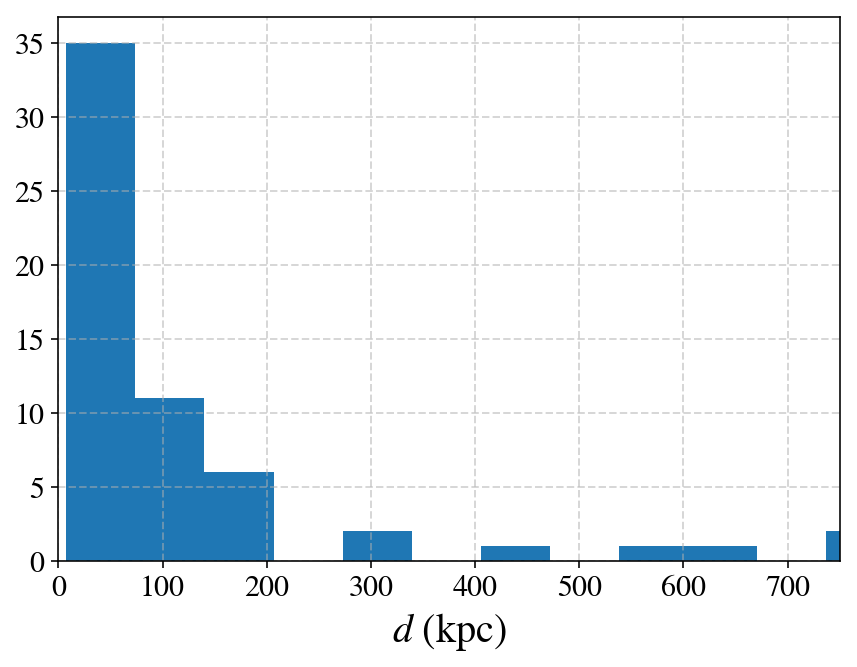

In [10]:
# now look at the distance histogram
fig = plt.figure(figsize=(7,5))

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax1.hist(pair_table['sep (kpc)'], bins = 500)
ax1.set_xlabel('$d$ (kpc)', fontsize = 20)
ax1.set_xlim([0,750])

This distribution is whack. I'm going to assume it is because of the mass cut. Or, there are true partner galaxies missing. I will only use table galaxies where $d < 200kpc$

In [11]:
good_pair_table = pair_table[np.where(pair_table['sep (kpc)'] < 200)[0]]
#good_pair_table

In [12]:
# set up table for analysis
hsc = hsc_xmm
# sort
hsc.remove_column('coord')
hsc.sort('logm_max')
hsc.reverse()

# add columns
hsc['coord'] = SkyCoord(hsc['ra']*u.deg, hsc['dec']*u.deg) # angular coordinate of each galaxy
hsc['flag'] = np.zeros(len(hsc['logm_max'])) 
hsc['index'] = np.zeros(len(hsc['logm_max']))


# cosmology
import colossus
from colossus.cosmology import cosmology
params = {'flat': True , 'H0': 70.0 , 'Om0': 0.3 , 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
h = .7
cosmology.addCosmology('huang18',params)
cosmology.setCosmology('huang18')
from colossus.halo import mass_so


# need halo radius
# this was using a virial radius, but alexie's notes say use 1Mpc
# r_halo = mass_so.M_to_R((10**hsc['logmh_vir_forest'])*h , hsc['z_best'], 'vir')/h # kpc
r_halo = 1e3 #kpc

# Turn the physical radius into an angular size in degrees
theta_per_kpc = FlatLambdaCDM(H0=70 , Om0= 0.3).arcsec_per_kpc_proper(hsc['z_best'])
r_halo_deg = ((r_halo*u.kpc * theta_per_kpc).to(u.deg))/u.deg

# add to table
hsc['r_halo'] = r_halo_deg

In [13]:
# use the pair table to identify centrals
for i in range(len(good_pair_table)):
    for j in range(len(hsc)):
        if good_pair_table['hsc_id'][i] == hsc['object_id'][j]:
            hsc['flag'][j] = -1

In [14]:
# make a catalog of just HSC centrals identified via xxl
hsc_centrals_from_xxl = hsc[np.where(hsc['flag'] == -1)[0]]
#hsc_centrals_from_xxl.write('hsc_centrals_from_xxl.fits', format = 'fits')

In [15]:
def satellite(i, table, z_lim):
   
    # the object we choose here is going to be a central by the way we have defined things
    if table['flag'][i] != 1:
    
        cent_gal = table[i] 
    
        # this was a trick that song used to make a new catalog for the other objects of interest.
        # the utility is that we don't have to loop through the whole catalog EVERY TIME
        table_use = copy.deepcopy(table[(table['logm_max'] < cent_gal['logm_max'])])
    
    
        # find the galaxies within the delta z limit
        dz= table_use[np.abs(cent_gal['z_best'] - table_use['z_best']) <= z_lim]
    
        if len(dz) > 0:
            # find separation for gals within dz
            dz['sep'] = cent_gal['coord'].separation(dz['coord']).degree 
        for i in range(len(dz)):
            if dz['sep'][i] <= cent_gal['r_halo']:
                table['flag'][int(dz['index'][i])] = 1
                #print('satellite, yo')

In [16]:
# other prep
# this was originally in a function I used for f_sat, but since this is a little different
# and in iPython nb, I'm doing it step by step

for i in range(len(hsc['index'])):
        hsc['index'][i] = i
        hsc['sep'] = np.zeros(len(hsc['logm_max'])) #column of angular separations

for idx in range(len(hsc)):
    satellite(idx, hsc, .004)

In [17]:
# separate into nice little tables
cents = hsc[hsc['flag'] != 1]
sats = hsc[hsc['flag'] == 1]

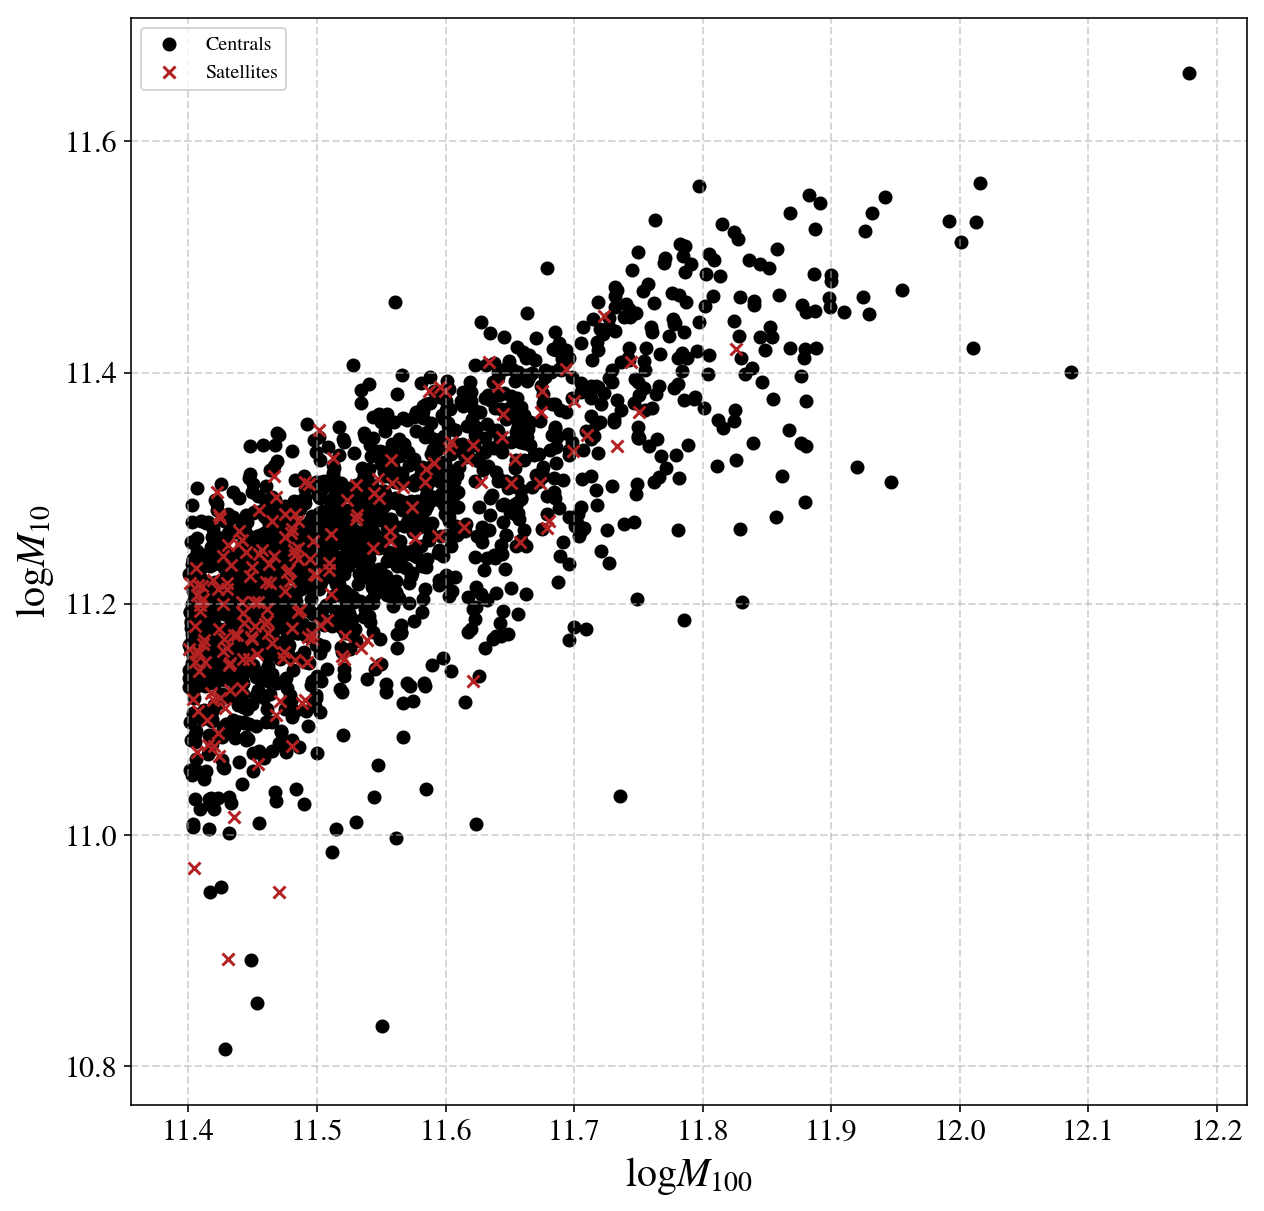

In [18]:
# plot the coordinate points
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
# centrals
ax1.scatter(cents['logm_100'], cents['logm_10'], marker = 'o', color = 'k', label = 'Centrals')


# satellites
ax1.scatter(sats['logm_100'], sats['logm_10'], marker = 'x', color = 'firebrick', label = 'Satellites')

ax1.set_xlabel('$\logM_{100}$', fontsize = 20)
ax1.set_ylabel('$\logM_{10}$', fontsize = 20)
ax1.legend()

In [19]:
mass_bins = [11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]

hist_all, edges_all = np.histogram(hsc['logm_max'], bins = mass_bins)

hist_cen, edges_cen = np.histogram(cents['logm_max'], bins = edges_all)

hist_sat, edges_sat = np.histogram(sats['logm_max'], bins = edges_all)

mass_center = np.log10((10**(edges_cen[1:]) + 10**(edges_cen[:-1])) / 2)

frac_sat = (hist_sat / hist_all) * 100.0
for k in range(len(frac_sat)):
    if np.isnan(frac_sat[k]) == True:
        frac_sat[k] = 0 
        
err = (np.sqrt(hist_sat) / hist_all) * 100.0 # poisson error bars 


No handles with labels found to put in legend.


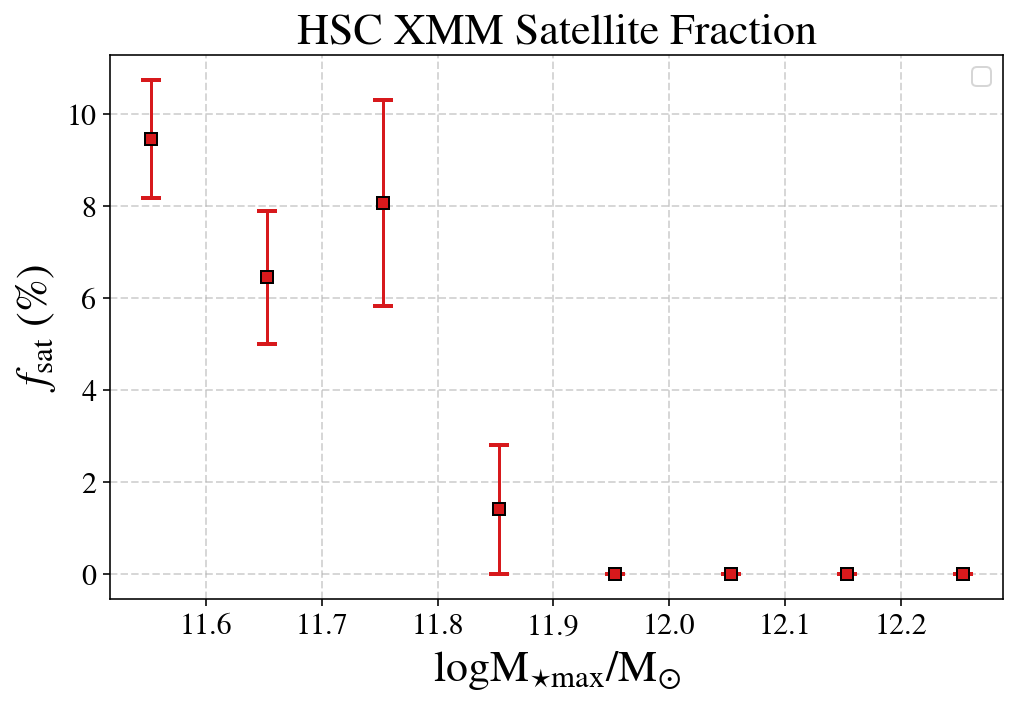

In [20]:
fig = plt.figure(figsize=(8,5))


ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.errorbar(mass_center, frac_sat, err, color = '#d7191c',fmt='s',mec = 'k',capthick=2, capsize=5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)



ax1.set_xlabel(r'$ \log \mathrm{M_{\star max} / M_{\odot}}$', fontsize=22)
ax1.set_ylabel(r'$f_{\mathrm{sat}}$ (%)', fontsize=22)
ax1.set_title('HSC XMM Satellite Fraction', fontsize = 22)
ax1.legend(fontsize = 12)


Text(0,0.5,'Mgas500kpc $(M_{halo})$?')

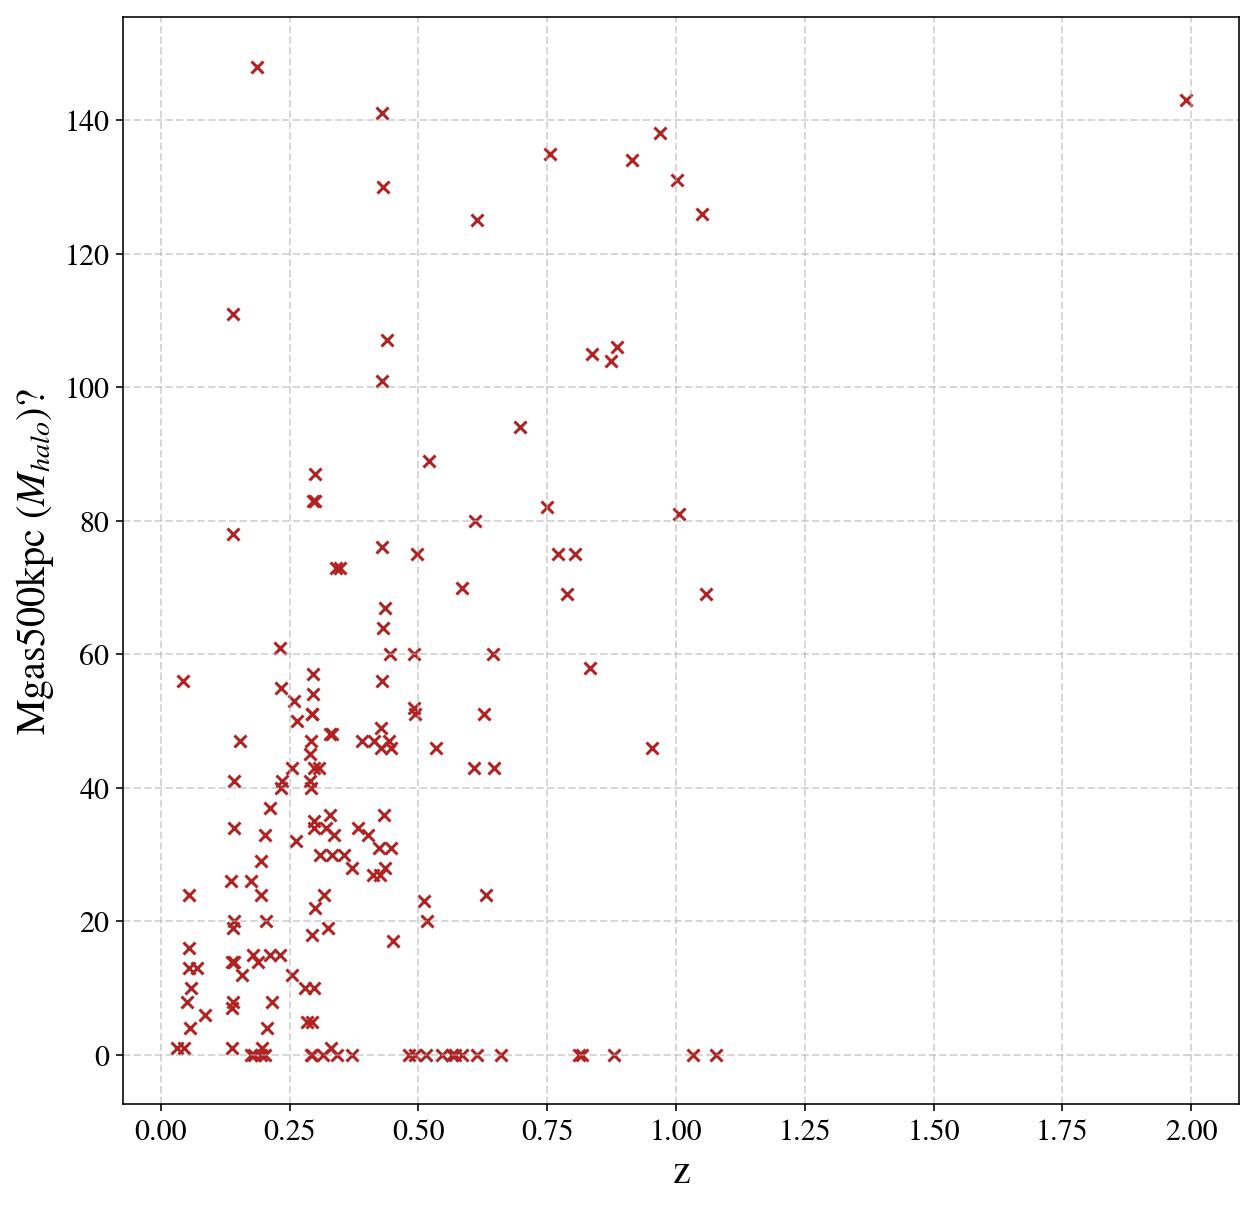

In [21]:

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)


# xxl
ax1.scatter(xxl_xmm['z'], xxl_xmm['Mgas500kpc'], marker = 'x', color = 'firebrick', label = 'XXL XMM')

# hsc
#ax1.scatter(hsc_xmm['z_best'], hsc_xmm['logm_max'], marker = 'o', color = 'k', label = 'HSC')

ax1.set_xlabel('z', fontsize = 20)
ax1.set_ylabel('Mgas500kpc $(M_{halo})$?', fontsize = 20)

In [22]:
# table operations hate these columns
xxl_xmm.remove_columns(['coord','Ngal'])
hsc_xmm.remove_column('coord')

From talking with Alexie, there are a few things that we want to look at. First, I want to determine how many x-ray sources are missing HSC counterparts. I'll use the 200kpc matching distance.

In [23]:
# the good galaxies are in good_pair_table. I'll go through the xxl_xmm and remove these to get a bad catalog

no_match_xxl = copy.deepcopy(xxl_xmm) # just copy the old table to modify
matches_full_data = Table(names = xxl_xmm.colnames) # match table with all columns of data

matching_rows = []



for i in range(len(good_pair_table)):
    for j in range(len(no_match_xxl)):
        if good_pair_table['xxl_id'][i] == no_match_xxl['XLSSC'][j]:
            matching_rows.append(j)
            matches_full_data.add_row(no_match_xxl[j])
no_match_xxl.remove_rows(matching_rows)

len(matches_full_data)

52

In [24]:
# write the table of matches to a file
#matches_full_data.write('xxl_matched_centrals.fits', format = 'fits')

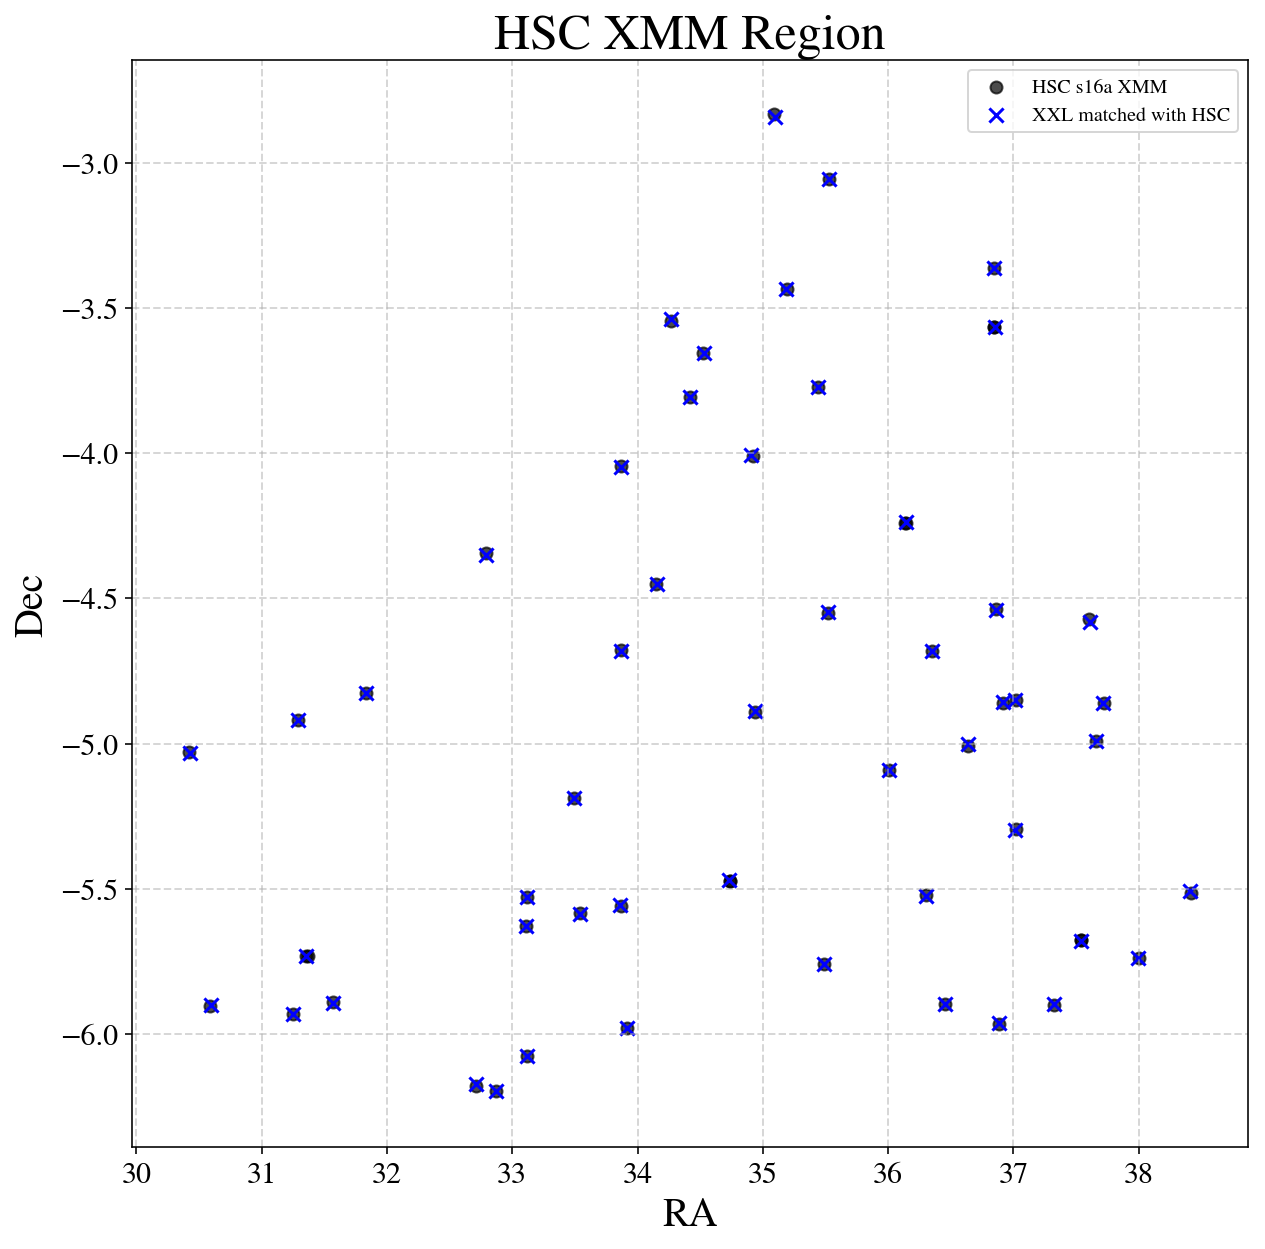

In [25]:
# how are the missing points distributed?
# plot the coordinate points
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
# hsc
ax1.scatter(hsc_centrals_from_xxl['ra'], hsc_centrals_from_xxl['dec'], marker = 'o', alpha = .7, color = 'k', label = 'HSC s16a XMM')

# xxl with match
ax1.scatter(matches_full_data['RAJ2000'], matches_full_data['DEJ2000'], marker = 'x', color = 'blue', s = 50, label = 'XXL matched with HSC')


# xxl missing match
#ax1.scatter(no_match_xxl['RAJ2000'], no_match_xxl['DEJ2000'], marker = 'x', color = 'firebrick', s = 50, label = 'XXL missing HSC partner')

ax1.set_xlabel('RA', fontsize = 20)
ax1.set_ylabel('Dec', fontsize = 20)
ax1.set_title('HSC XMM Region', fontsize = 25)
ax1.legend()

I wasn't careful with the redshifts! There are XXL sources that are **NOT** in the range of the HSC redshifts.

In [26]:
# let's get rid of the bad redshifts
# use the min and max of the HSC \pm 0.01
# Only the ones missing matches would be outside of this range

z_min_xxl = np.min(hsc_xmm['z_best']) - 0.01
z_max_xxl = np.max(hsc_xmm['z_best']) + 0.01

no_match_xxl = no_match_xxl[no_match_xxl['z'] > z_min_xxl]
no_match_xxl = no_match_xxl[no_match_xxl['z'] < z_max_xxl]

Text(0.5,0,'z')

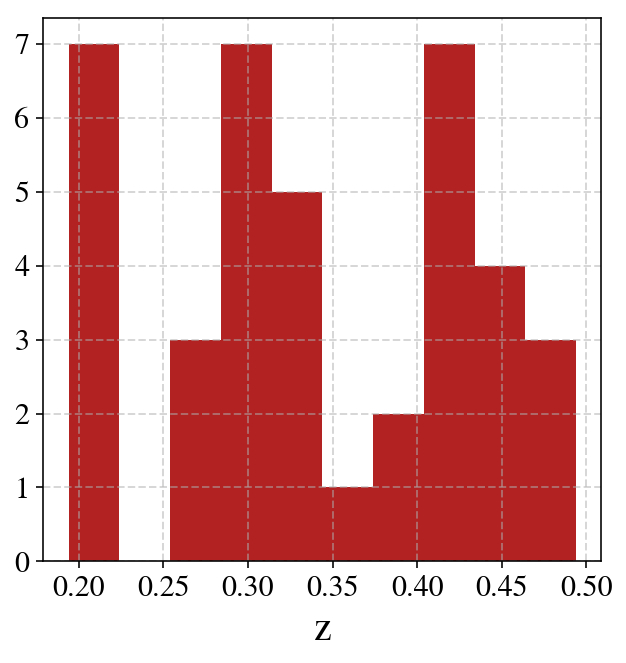

In [27]:
# check distrobution of redshifts

fig = plt.figure(figsize=(5,5))

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)


# xxl
ax1.hist(no_match_xxl['z'], color = 'firebrick')
ax1.set_xlabel('z', fontsize = 20)


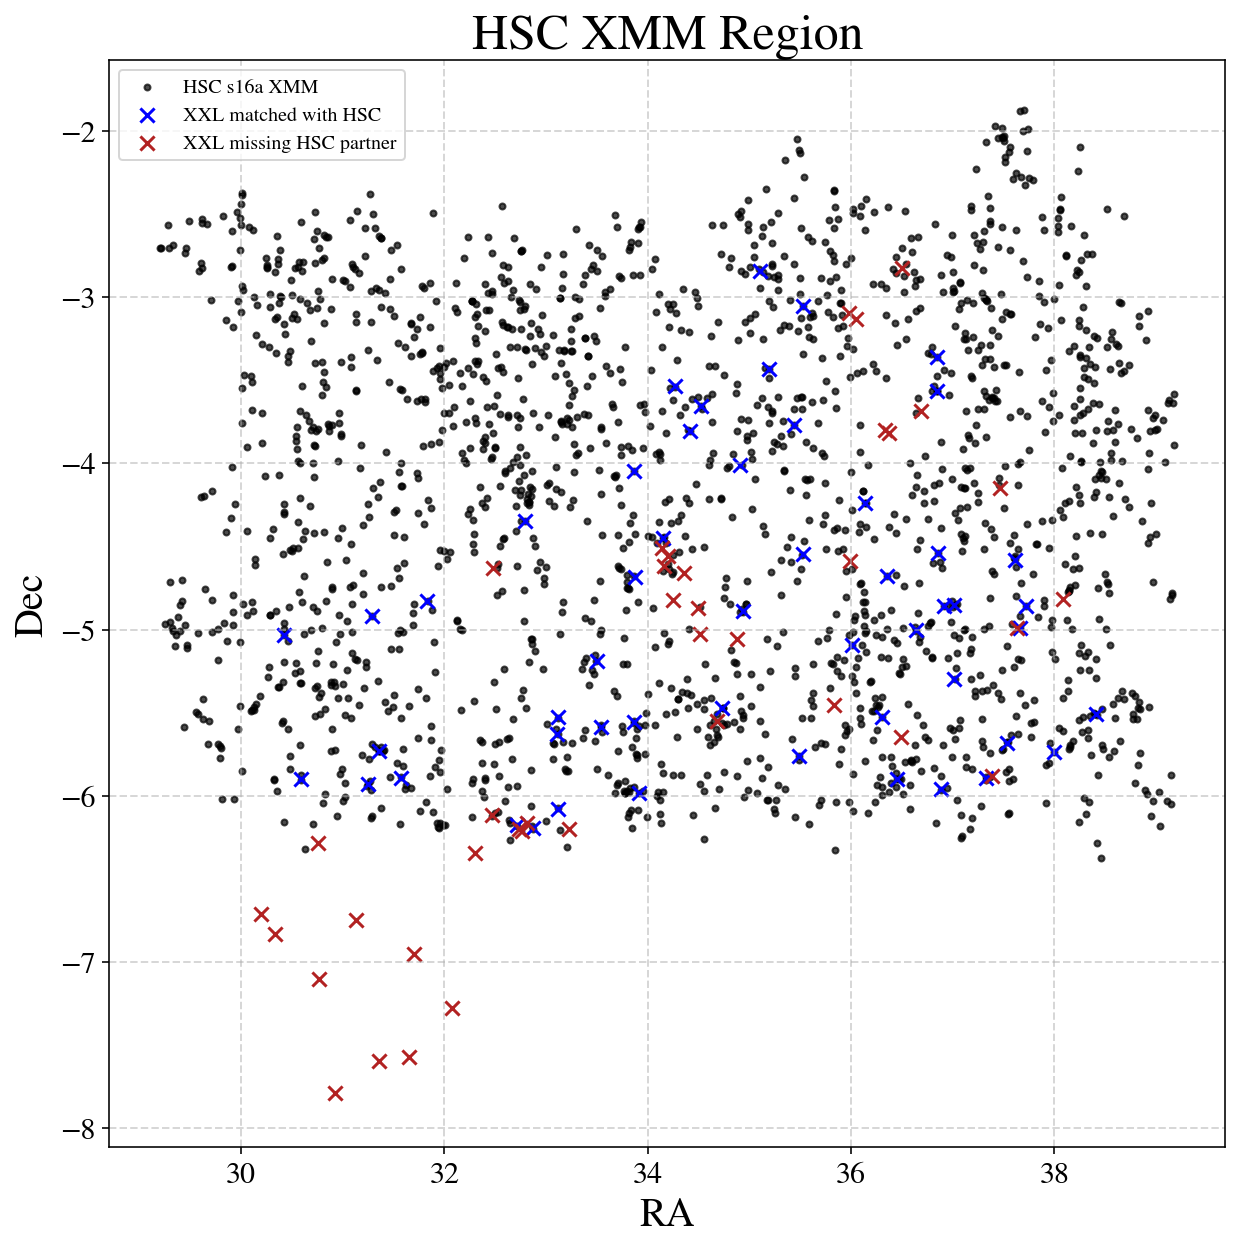

In [28]:
# make the above plot, but with the better distribution

# how are the missing points distributed?
# plot the coordinate points
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
# hsc
ax1.scatter(hsc_xmm['ra'], hsc_xmm['dec'], marker = '.', alpha = .7, color = 'k', label = 'HSC s16a XMM')

# xxl with match
ax1.scatter(matches_full_data['RAJ2000'], matches_full_data['DEJ2000'], marker = 'x', color = 'blue', s = 50, label = 'XXL matched with HSC')


# xxl missing match
ax1.scatter(no_match_xxl['RAJ2000'], no_match_xxl['DEJ2000'], marker = 'x', color = 'firebrick', s = 50, label = 'XXL missing HSC partner')

ax1.set_xlabel('RA', fontsize = 20)
ax1.set_ylabel('Dec', fontsize = 20)
ax1.set_title('HSC XMM Region', fontsize = 25)
ax1.legend()

In [29]:
# make list for Song
missing_points = Table()
missing_points['ra'] = no_match_xxl['RAJ2000']
missing_points['dec'] = no_match_xxl['DEJ2000']
missing_points['z'] = no_match_xxl['z']

# export the table for Song
#missing_points.write('xxl_xmm_no_hsc_partner.fits', format = 'fits')

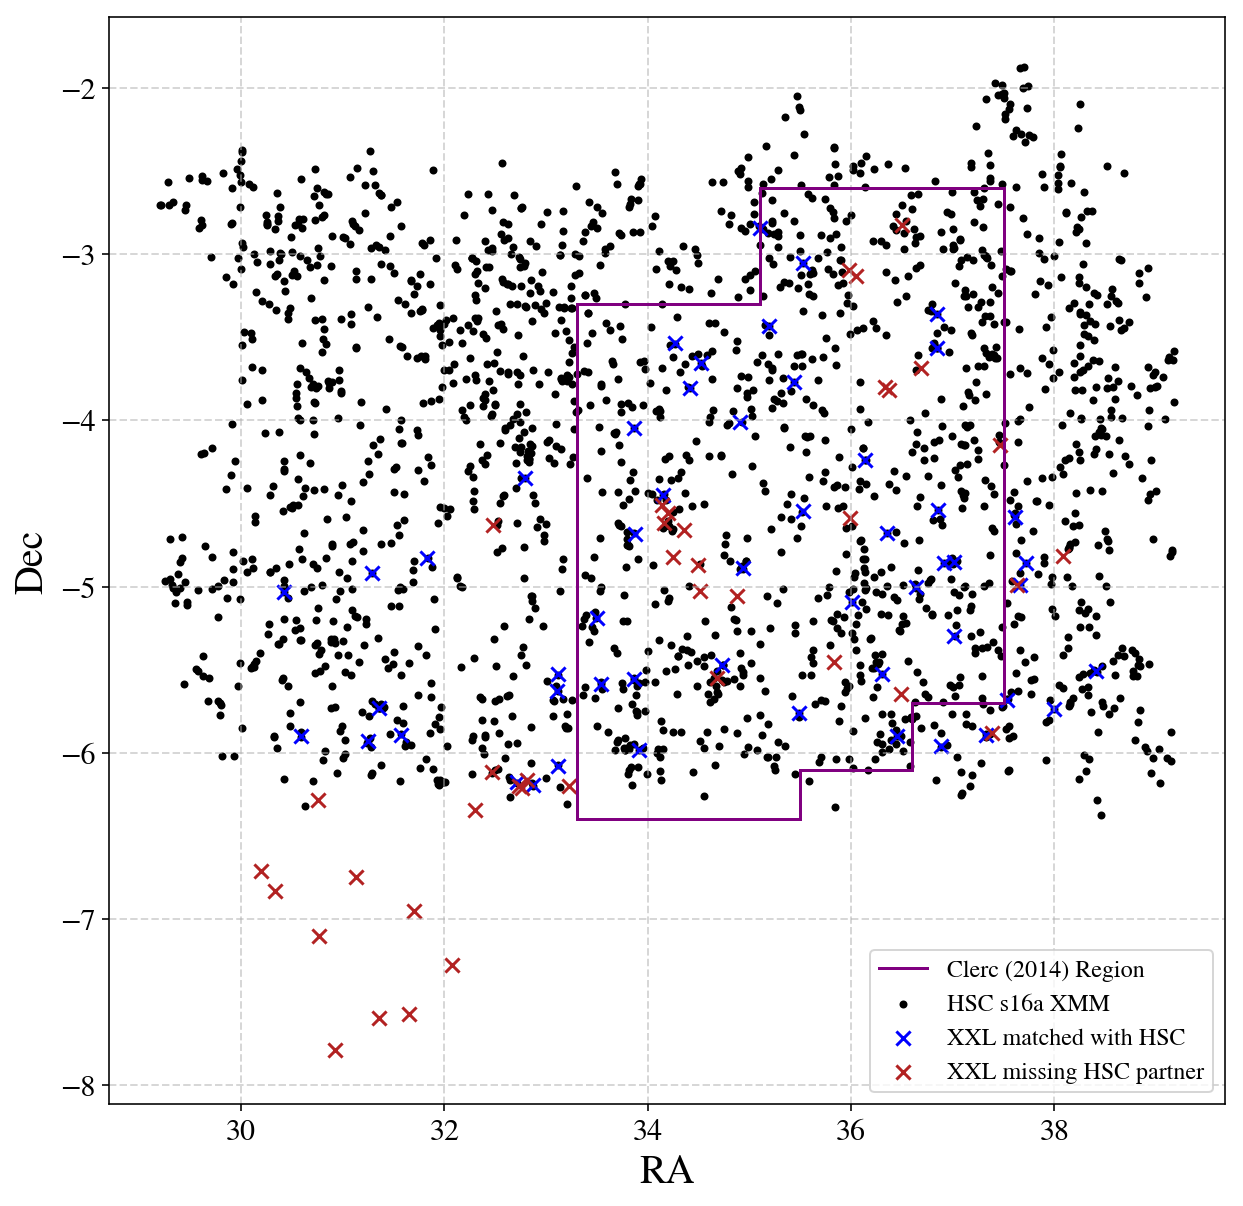

In [30]:
# plot ALL of the coordinate points
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
# hsc
ax1.scatter(hsc_xmm['ra'], hsc_xmm['dec'], marker = '.', color = 'k', label = 'HSC s16a XMM')

# xxl with match
ax1.scatter(matches_full_data['RAJ2000'], matches_full_data['DEJ2000'], marker = 'x', color = 'blue', s = 50, label = 'XXL matched with HSC')


# xxl missing match
ax1.scatter(no_match_xxl['RAJ2000'], no_match_xxl['DEJ2000'], marker = 'x', color = 'firebrick', s = 50, label = 'XXL missing HSC partner')

# xmm box
ax1.plot([37.5,37.5], [-5.7,-2.6], color = 'purple', label = 'Clerc (2014) Region')
ax1.plot([36.6,36.6], [-5.7,-6.1], color = 'purple')
ax1.plot([37.5,36.6], [-5.7,-5.7], color = 'purple')
ax1.plot([36.6,35.5], [-6.1,-6.1], color = 'purple')
ax1.plot([35.5,35.5], [-6.1,-6.4], color = 'purple')
ax1.plot([35.5,33.3], [-6.4,-6.4], color = 'purple')
ax1.plot([33.3,33.3], [-6.4,-3.3], color = 'purple')
ax1.plot([33.3,35.1], [-3.3,-3.3], color = 'purple')
ax1.plot([35.1,35.1], [-3.3,-2.6], color = 'purple')
ax1.plot([35.1,37.5], [-2.6,-2.6], color = 'purple')


ax1.set_xlabel('RA', fontsize = 20)
ax1.set_ylabel('Dec', fontsize = 20)
ax1.legend(fontsize = 12)

## Now I will re-do the satellite analysis based on the rough cut from Clerc (2014). I'll select galaxies by systematically looking at rectangles inside of this region.

I'll do a very rough rectangular cut, probably in a horribly inefficient way.

In [31]:
clerc_region_xxl = Table(names = xxl_xmm.colnames)
clerc_region_hsc = Table(names = hsc_xmm.colnames)

for i in range(len(xxl_xmm)):
    if xxl_xmm['RAJ2000'][i] < 37.5 \
    and xxl_xmm['RAJ2000'][i] > 33.3 \
    and xxl_xmm['DEJ2000'][i] > -6.4 \
    and xxl_xmm['DEJ2000'][i] < -2.6:
        clerc_region_xxl.add_row(xxl_xmm[i])
        
non_region_xxl = []
for i in range(len(clerc_region_xxl)):
    if clerc_region_xxl['RAJ2000'][i] < 35.0 and clerc_region_xxl['DEJ2000'][i] > -3.3:
        non_region_xxl.append(i)
clerc_region_xxl.remove_rows(non_region_xxl)

for i in range(len(hsc_xmm)):
    if hsc_xmm['ra'][i] < 37.5 \
    and hsc_xmm['ra'][i] > 33.3 \
    and hsc_xmm['dec'][i] > -6.4 \
    and hsc_xmm['dec'][i] < -2.6:
        clerc_region_hsc.add_row(hsc_xmm[i])
        
non_region_hsc = []
for i in range(len(clerc_region_hsc)):
    if clerc_region_hsc['ra'][i] < 35.1 and clerc_region_hsc['dec'][i] > -3.3:
        non_region_hsc.append(i)
clerc_region_hsc.remove_rows(non_region_hsc)

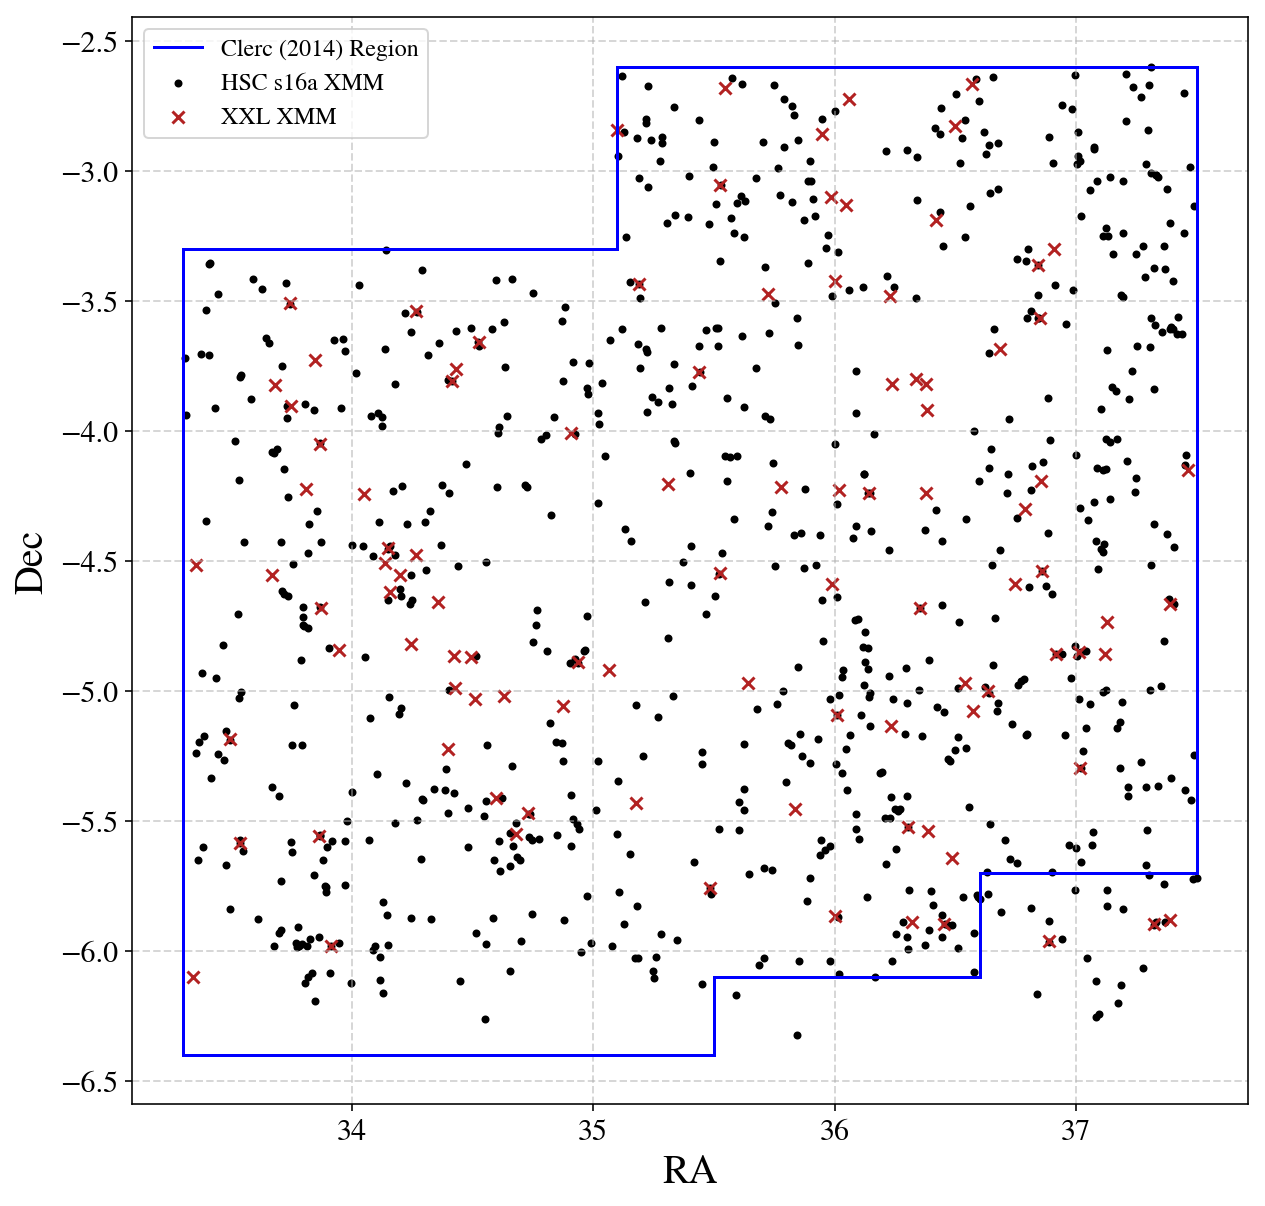

In [32]:
# plot the coordinate points
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
# hsc
ax1.scatter(clerc_region_hsc['ra'], clerc_region_hsc['dec'], marker = '.', color = 'k', label = 'HSC s16a XMM')

# xxl
ax1.scatter(clerc_region_xxl['RAJ2000'], clerc_region_xxl['DEJ2000'], marker = 'x', color = 'firebrick', label = 'XXL XMM')

# xmm box
ax1.plot([37.5,37.5], [-5.7,-2.6], color = 'blue', label = 'Clerc (2014) Region')
ax1.plot([36.6,36.6], [-5.7,-6.1], color = 'blue')
ax1.plot([37.5,36.6], [-5.7,-5.7], color = 'blue')
ax1.plot([36.6,35.5], [-6.1,-6.1], color = 'blue')
ax1.plot([35.5,35.5], [-6.1,-6.4], color = 'blue')
ax1.plot([35.5,33.3], [-6.4,-6.4], color = 'blue')
ax1.plot([33.3,33.3], [-6.4,-3.3], color = 'blue')
ax1.plot([33.3,35.1], [-3.3,-3.3], color = 'blue')
ax1.plot([35.1,35.1], [-3.3,-2.6], color = 'blue')
ax1.plot([35.1,37.5], [-2.6,-2.6], color = 'blue')


ax1.set_xlabel('RA', fontsize = 20)
ax1.set_ylabel('Dec', fontsize = 20)
ax1.legend(fontsize = 12)

I made a very rough cut according to the region in Clerc (2014), except for the low galaxies at the bottom right. I will look at our statistics with these now.

In [33]:
# repeat above analysis

# need a 'coord' column for my function
clerc_region_xxl['coord'] = SkyCoord(clerc_region_xxl['RAJ2000']*u.deg, clerc_region_xxl['DEJ2000']*u.deg)
clerc_region_hsc['coord'] = SkyCoord(clerc_region_hsc['ra']*u.deg, clerc_region_hsc['dec']*u.deg)

pair_table = Table(names = ('xxl_id', 'T300kpc', 'hsc_id', 'z', 'hsc_logm', 'sep (arcsec)'))

# now I will run the function. This is not efficient, but oh well
for j in range(len(clerc_region_xxl)):
    match_galaxy(j, clerc_region_xxl, clerc_region_hsc, 0.01)
    
# function uses arcmin, so I'll make a sep column in arcmin
pair_table['sep (arcmin)'] = (pair_table['sep (arcsec)']*u.arcsec).to(u.arcmin)/u.arcmin
pair_table['sep (kpc)'] = FlatLambdaCDM(H0=70 , Om0= 0.3).kpc_proper_per_arcmin(pair_table['z']) * pair_table['sep (arcmin)'] *(u.arcmin/u.kpc)

# call the good galaxies where d<200kpc
good_pair_table = pair_table[np.where(pair_table['sep (kpc)'] < 200)[0]]

# set up table for analysis
hsc = clerc_region_hsc
# sort
hsc.remove_column('coord')
hsc.sort('logm_max')
hsc.reverse()

# add columns
hsc['coord'] = SkyCoord(hsc['ra']*u.deg, hsc['dec']*u.deg) # angular coordinate of each galaxy
hsc['flag'] = np.zeros(len(hsc['logm_100'])) 
hsc['index'] = np.zeros(len(hsc['logm_100']))

# need halo radius
# this was using a virial radius, but alexie's notes say use 1Mpc
# r_halo = mass_so.M_to_R((10**hsc['logmh_vir_forest'])*h , hsc['z_best'], 'vir')/h # kpc
r_halo = 1e3 #kpc

# Turn the physical radius into an angular size in degrees
theta_per_kpc = FlatLambdaCDM(H0=70 , Om0= 0.3).arcsec_per_kpc_proper(hsc['z_best'])
r_halo_deg = ((r_halo*u.kpc * theta_per_kpc).to(u.deg))/u.deg

# add to table
hsc['r_halo'] = r_halo_deg

# use the pair table to identify centrals
for i in range(len(good_pair_table)):
    for j in range(len(hsc)):
        if good_pair_table['hsc_id'][i] == hsc['object_id'][j]:
            hsc['flag'][j] = -1
            
# other prep
# this was originally in a function I used for f_sat, but since this is a little different
# and in iPython nb, I'm doing it step by step

for i in range(len(hsc['index'])):
        hsc['index'][i] = i
        hsc['sep'] = np.zeros(len(hsc['logm_100'])) #column of angular separations

for idx in range(len(hsc)):
    satellite(idx, hsc, .004)
    
# separate into nice little tables
cents = hsc[hsc['flag'] != 1]
sats = hsc[hsc['flag'] == 1]

In [34]:
mass_bins = [11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]

hist_all, edges_all = np.histogram(hsc['logm_100'], bins = mass_bins)

hist_cen, edges_cen = np.histogram(cents['logm_100'], bins = edges_all)

hist_sat, edges_sat = np.histogram(sats['logm_100'], bins = edges_all)

mass_center = np.log10((10**(edges_cen[1:]) + 10**(edges_cen[:-1])) / 2)

frac_sat = (hist_sat / hist_all) * 100.0
for k in range(len(frac_sat)):
    if np.isnan(frac_sat[k]) == True:
        frac_sat[k] = 0 
        
err = (np.sqrt(hist_sat) / hist_all) * 100.0 # poisson error bars 

/Users/astro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/astro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


[403 187 123  49  24   4   4   0   0]


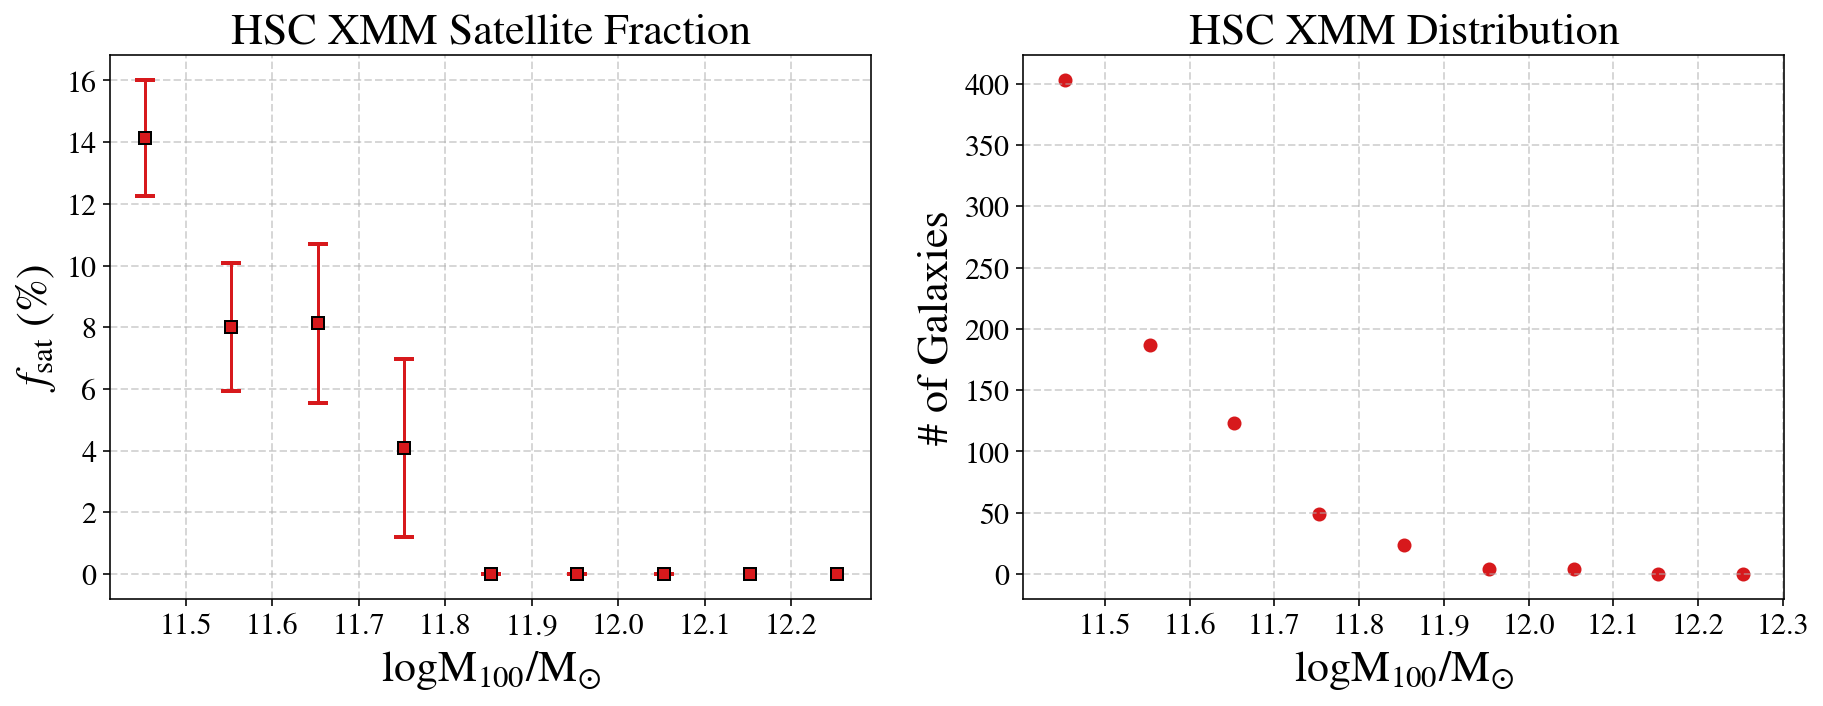

In [35]:
fig = plt.figure(figsize=(15,5))


ax1 = fig.add_subplot(121)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.errorbar(mass_center, frac_sat, err, color = '#d7191c',fmt='s',mec = 'k',capthick=2, capsize=5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)



ax1.set_xlabel(r'$ \log \mathrm{M_{100} / M_{\odot}}$', fontsize=22)
ax1.set_ylabel(r'$f_{\mathrm{sat}}$ (%)', fontsize=22)
ax1.set_title('HSC XMM Satellite Fraction', fontsize = 22)
#ax1.legend(fontsize = 12)

ax2 = fig.add_subplot(122)
ax2.grid(linewidth=1, linestyle='--', alpha=0.5)

ax2.scatter(mass_center, hist_all, color = '#d7191c')

for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)



ax2.set_xlabel(r'$ \log \mathrm{M_{100} / M_{\odot}}$', fontsize=22)
ax2.set_ylabel(r'# of Galaxies', fontsize=22)
ax2.set_title('HSC XMM Distribution', fontsize = 22)
print(hist_all)

# Now make the plots that Alexie and I talked about on 3/5

### First get the mask and points therein

In [124]:
nobu_mask_file = data_pth + 'mask_bounds.fits'
hsc_masked_file = data_pth + 's16a_massive_mvir_added_xmm_masked.fits'
xxl_masked_file = data_pth + 'xxl_365_masked.fits'

hsc_masked = Table(fits.open(hsc_masked_file)[1].data)
xxl_masked = Table(fits.open(xxl_masked_file)[1].data)
nobu_mask = Table(fits.open(nobu_mask_file)[1].data)

# change the xxl catalog that is in same region as the hsc data
xxl_masked = xxl_masked[xxl_masked['z'] >= 0.19]
xxl_masked = xxl_masked[xxl_masked['z'] <= 0.51]

# mass cut for the HSC galaxies (logm_max > 11.4)
hsc_masked = hsc_masked[hsc_masked['logm_100'] > 11.4]
hsc_masked = hsc_masked[hsc_masked['z_best'] > 0.2]
hsc_masked = hsc_masked[hsc_masked['z_best'] < 0.5]

hsc_z = hsc_masked['z_best']

In [130]:
np.array(hsc_z)

array([0.48881   , 0.48956001, 0.48958999, ..., 0.49516013, 0.49854326,
       0.49875203])

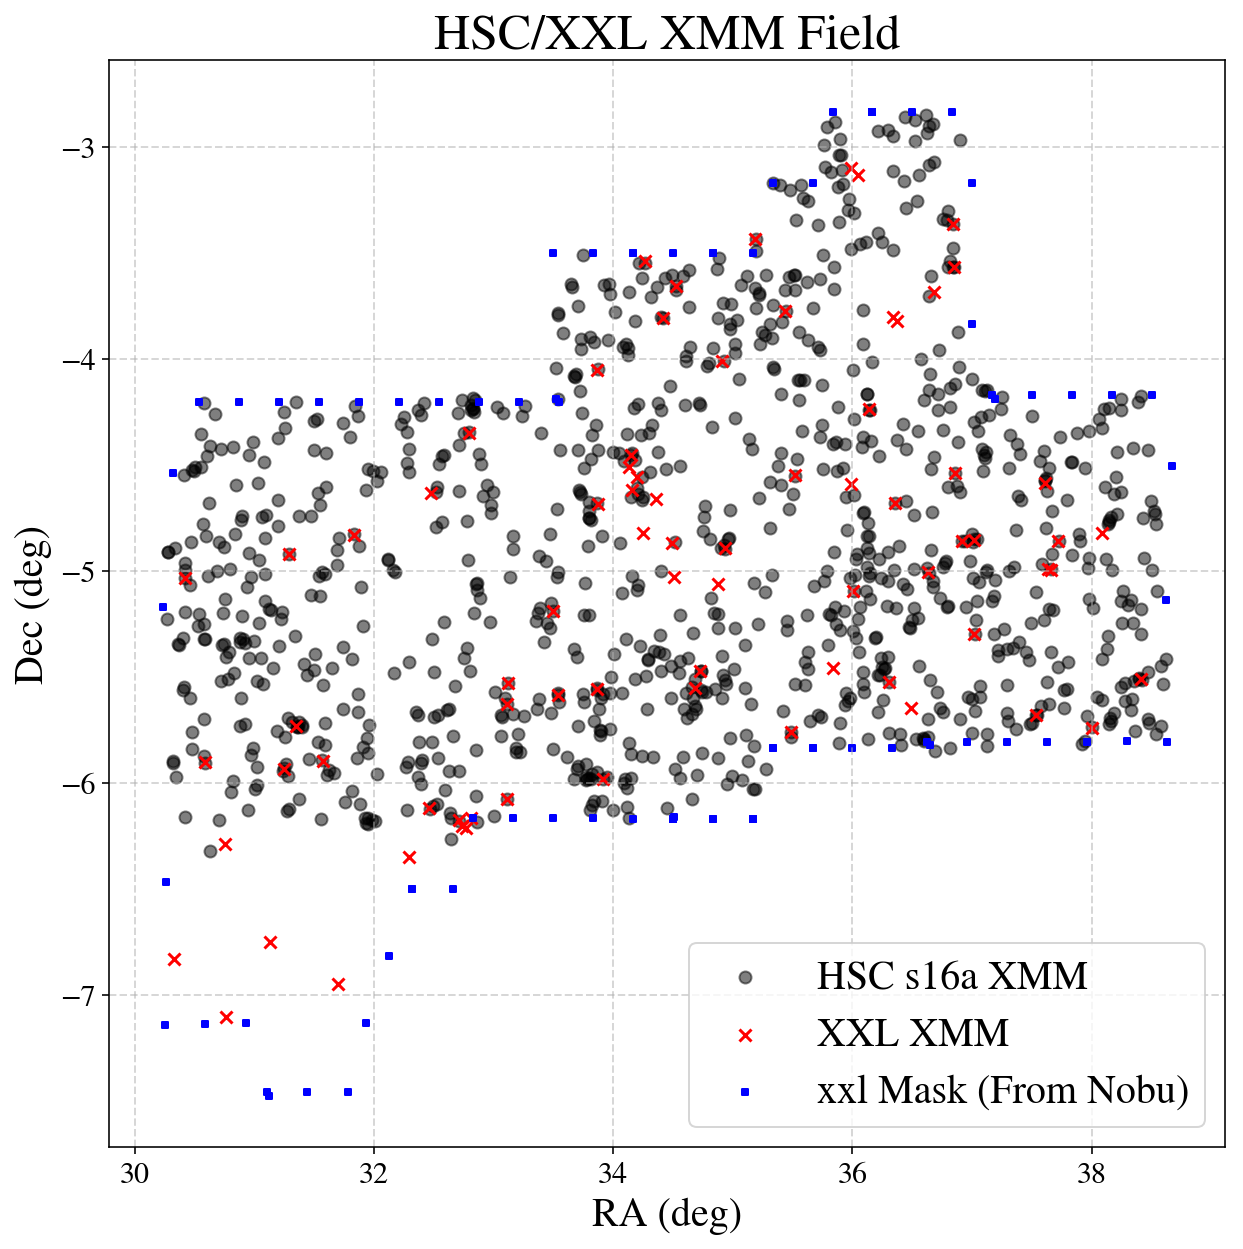

In [156]:
# plot the coordinate points
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
# hsc
xy = np.vstack([hsc_masked['ra'],hsc_masked['dec']])
z = gaussian_kde(xy)(xy)
ax1.scatter(hsc_masked['ra'], hsc_masked['dec'], marker = 'o', color = 'k', alpha = 0.5,label = 'HSC s16a XMM')

# xxl
ax1.scatter(xxl_masked['RAJ2000'], xxl_masked['DEJ2000'], marker = 'x', color = 'red', label = 'XXL XMM')

# mask points
ax1.scatter(nobu_mask['ra'], nobu_mask['dec'], marker = 's', s = 7, color = 'blue', label = 'xxl Mask (From Nobu)')
#ax1.fill(nobu_mask['ra'], nobu_mask['dec'])
# pretty region
#xy = np.array([nobu_mask['ra'],nobu_mask['dec']])
#xy_swapped = np.swapaxes(xy,0,1)
#patches = []
#patches.append(Polygon(xy_swapped,True))
#p = PatchCollection(patches,alpha = 0.4)
#ax1.add_collection(p)


ax1.set_xlabel('RA (deg)', fontsize = 20)
ax1.set_ylabel('Dec (deg)', fontsize = 20)
ax1.set_title('HSC/XXL XMM Field', fontsize = 25)
ax1.legend(fontsize = 20)

# Make figure of M$_{500}$ vs z


In doing this, my operation is as follows:
$$ \log M_{500} = Mgas_{500, XXL} \times 10^{13} \times 0.7^{-1}$$

In [77]:
M_500 = (xxl_masked['Mgas500kpc'] * 1e13) / 0.7 
logm_500 = np.log10(M_500)

/Users/astro/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


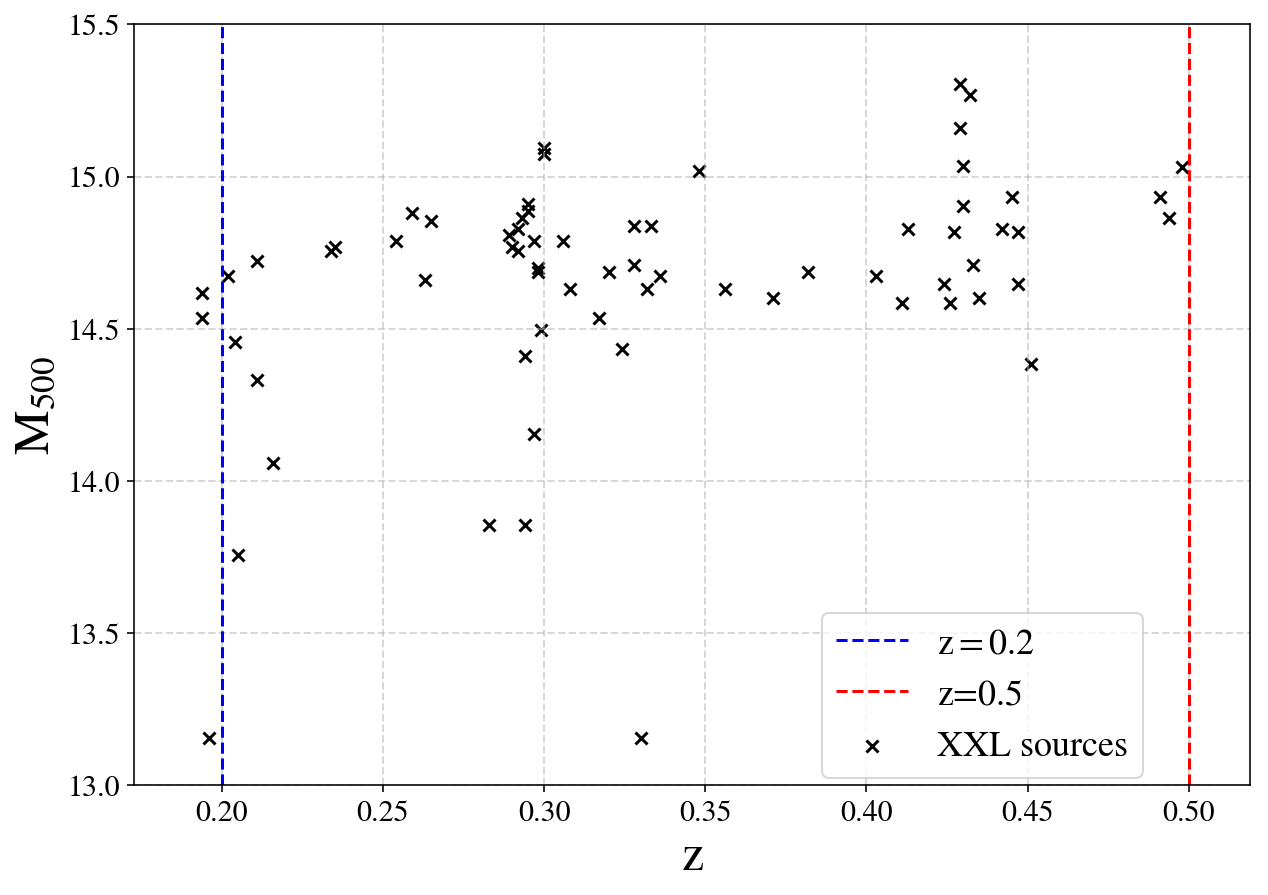

In [95]:
# plot the coordinate points
fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
    
# xxl
ax1.scatter(xxl_masked['z'], logm_500, marker = 'x', color = 'k', label = 'XXL sources')

# bounds
ax1.plot([0.2,0.2],[13.0,15.5], color = 'blue', ls = '--', label = 'z$=0.2$')
ax1.plot([0.5,0.5],[13.0,15.5], color = 'red', ls = '--', label = 'z=$0.5$')

ax1.set_ylim(13.0,15.5)
ax1.set_xlabel('z',fontsize = 25)
ax1.set_ylabel('M$_{500}$',fontsize = 25)
ax1.legend(fontsize = 18, bbox_to_anchor=(0.6, 0.25))

### Now make that two-panel figure

In [104]:
import matplotlib.image as mpimg
from PIL import Image
img = Image.open('/Users/astro/Downloads/image.png')
img.show()

Text(0.5,1,"Chris' Plot")

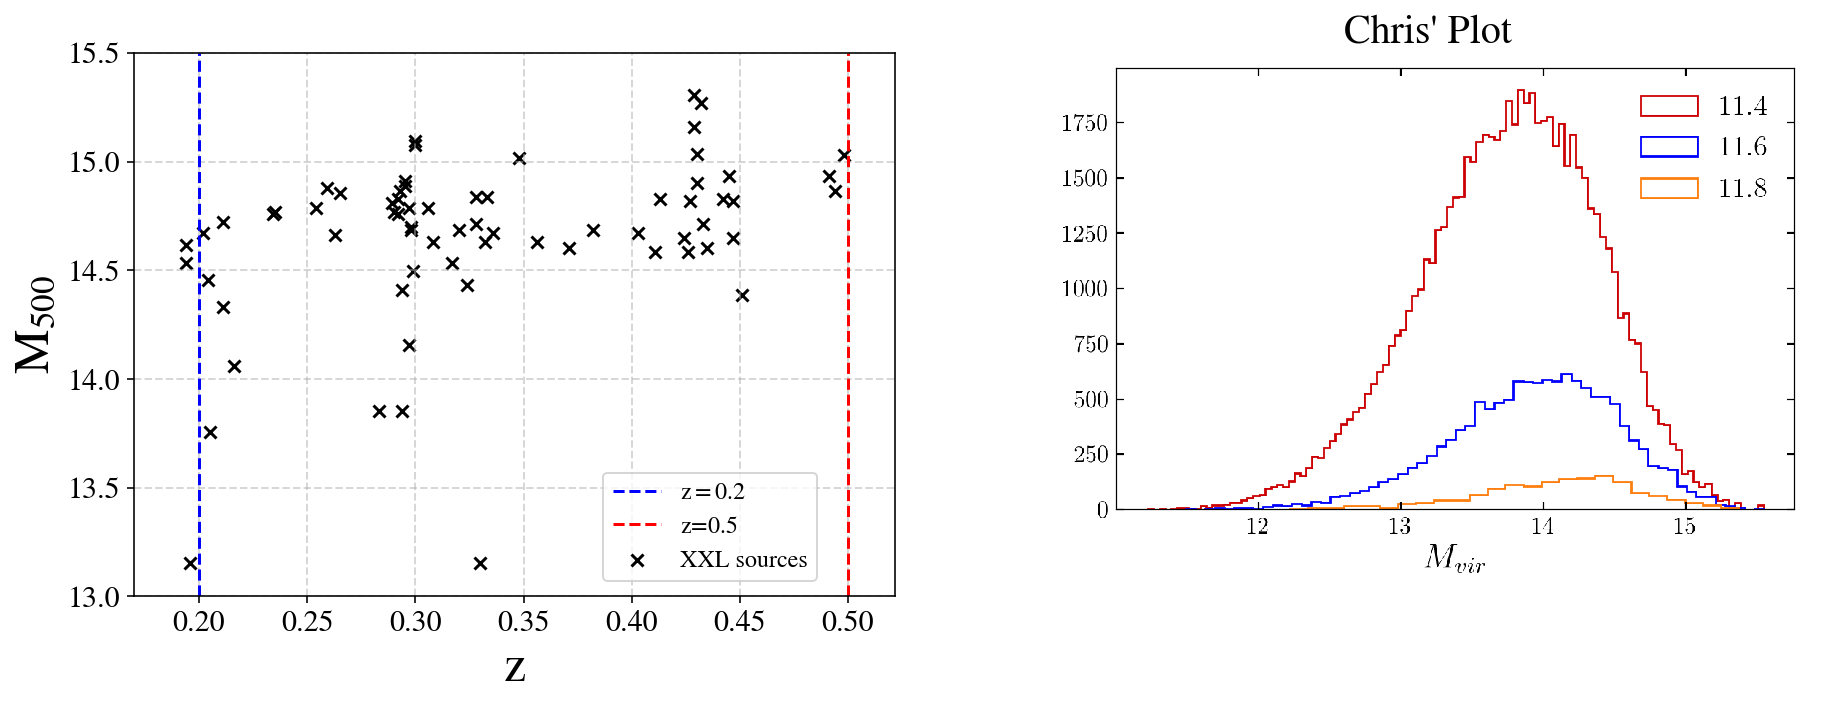

In [114]:
# plot the coordinate points
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
    
# xxl
ax1.scatter(xxl_masked['z'], logm_500, marker = 'x', color = 'k', label = 'XXL sources')

# bounds
ax1.plot([0.2,0.2],[13.0,15.5], color = 'blue', ls = '--', label = 'z$=0.2$')
ax1.plot([0.5,0.5],[13.0,15.5], color = 'red', ls = '--', label = 'z=$0.5$')

ax1.set_ylim(13.0,15.5)
ax1.set_xlabel('z',fontsize = 25)
ax1.set_ylabel('M$_{500}$',fontsize = 25)
ax1.legend(fontsize = 12, bbox_to_anchor=(0.6, 0.25))

ax2 = fig.add_subplot(122)
ax2.imshow(np.asarray(img))
ax2.axis('off')
ax2.set_title('Chris\' Plot', fontsize = 20)